To reproduce ASIC AE EMD Pipeline results

In [28]:
import os
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import numba

from utils.metrics import emd
from utils.metrics import hexMetric

import scipy
from scipy import stats, optimize, interpolate

In [4]:
def load_data(inputFile):
    data=pd.read_csv(inputFile,usecols=[*range(0,48)])
    data_values=data.values
            
    return data_values

def load_eta(inputFile):
    data=pd.read_csv(inputFile,usecols=[48])
    data_values=data.to_numpy().flatten()
            
    return data_values

In [5]:
input_data = load_data('/ecoderemdvol/QK/low_pt_high_eta/8x8_c8_S2_qK_RTL_emd_lphe/verify_input_calQ.csv')

In [8]:
ae_tele_output = load_data('/ecoderemdvol/QK/low_pt_high_eta/8x8_c8_S2_qK_RTL_tele/verify_decoded_calQ.csv')
ae_emd_output  = load_data('/ecoderemdvol/QK/low_pt_high_eta/8x8_c8_S2_qK_RTL_emd_lphe/verify_decoded_calQ.csv')

In [9]:
stored_emd = pd.read_csv('/ecoderemdvol/QK/comp/test/comp.csv')

In [18]:
emd_emd  = stored_emd['emd_nn_loss_emd'].values # EMD between input and output when using emd nn loss
tele_emd = stored_emd['tele_loss_emd'].values   # EMD between input and output when using telescope loss

Plot EMD[AE_input,AE_output] vs 3 metrics: occupancy and sum of charges, and wafer eta

In [59]:
#occupancy of trigger cells in wafers with one minimum ionizing particle
occupancy_1MT = np.count_nonzero(input_data.reshape(len(input_data),48)>1.,axis=1)

#wafer eta of data

eta = stored_emd['emd_nn_loss_eta'].values

In [29]:
@numba.jit
def normalize(data,rescaleInputToMax=False, sumlog2=True):
    maxes =[]
    sums =[]
    sums_log2=[]
    for i in range(len(data)):
        maxes.append( data[i].max() )
        sums.append( data[i].sum() )
        sums_log2.append( 2**(np.floor(np.log2(data[i].sum()))) )
        if sumlog2:
            data[i] = 1.*data[i]/(sums_log2[-1] if sums_log2[-1] else 1.)
        elif rescaleInputToMax:
            data[i] = 1.*data[i]/(data[i].max() if data[i].max() else 1.)
        else:
            data[i] = 1.*data[i]/(data[i].sum() if data[i].sum() else 1.)
    if sumlog2:
        return  data,np.array(maxes),np.array(sums_log2)
    else:
        return data,np.array(maxes),np.array(sums)

In [93]:
# log_10(sum of TC charges/ normalized to units of one minimum ionizing particle)

# normalize input charge data
# rescaleInputToMax: normalizes charges to maximum charge in module
# sumlog2 (default): normalizes charges to 2**floor(log2(sum of charge in module)) where floor is the largest scalar integer: i.e. normalizes to MSB of the sum of charges (MSB here is the most significant bit)
# rescaleSum: normalizes charges to sum of charge in module


normdata,maxdata,sumdata = normalize(input_data.copy(),rescaleInputToMax=False,sumlog2=True)
maxdata = maxdata / 35. # normalize to units of transverse MIPs
sumdata = sumdata / 35. # normalize to units of transverse MIPs

In [94]:
sum_tc_mipt = (np.log10(sumdata.flatten()))

In [95]:
x_labels = [r'occupancy[1 MIP$_{T}$] TCs', r'log10(Sum of TC charges/MIP$_{T}$)',r'$|\eta|$']
legends = ['telescope loss', 'EMD NN loss']
image_name = ['occ','sumtc','eta']

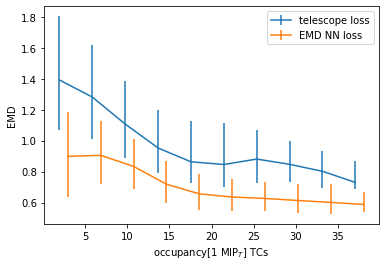

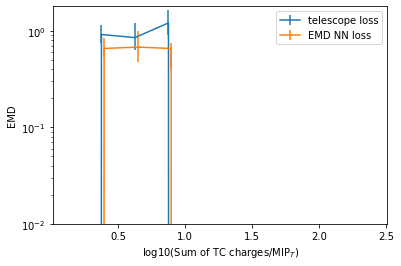

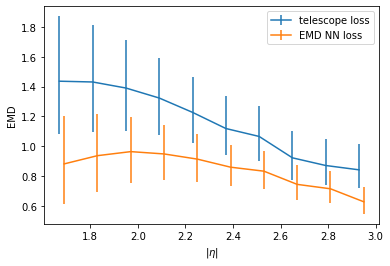

In [96]:
for x_it, x in enumerate((occupancy_1MT, sum_tc_mipt, eta)):
    
    offsets = [0,0.02]
    
    for y_it,y in enumerate((tele_emd, emd_emd)):
        
        nbins=10
        stats=True
        lims = (x.min(),x.max())
        if x_it ==0:
            offsets = [0,1]
        if x_it == 1:
            lims = (0.0,2.5)
            plt.ylim(0.01,1.8)
            plt.yscale('log')
        if x_it == 2:
            lims = (1.6,3.0)
        median_result = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5))
        lo_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5-0.68/2))
        hi_result     = scipy.stats.binned_statistic(x, y, bins=nbins, range=lims, statistic=lambda x: np.quantile(x,0.5+0.68/2))
        median = np.nan_to_num(median_result.statistic)
        hi = np.nan_to_num(hi_result.statistic)
        lo = np.nan_to_num(lo_result.statistic)
        hie = hi-median
        loe = median-lo
        bin_edges = median_result.bin_edges
        bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
        
        off = offsets[y_it]

        plt.errorbar(x=bin_centers + off , y=median, yerr=[loe,hie],label = legends[y_it])
    plt.xlabel(x_labels[x_it])
    plt.ylabel('EMD')
    plt.legend()
    #plt.savefig(image_name[x_it]+'.pdf',dpi=600)
    plt.show()
    plt.close()